<a href="https://colab.research.google.com/github/rimiiii/basic/blob/main/torch_CNN_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모듈 불러오기

In [ ]:
import torch
import torch.nn as nn #네트워크
import torch.nn.functional as F #함수
import torch.optim as optim #최적화 알고리즘
from torchvision import datasets, transforms #데이터셋, 이미지 변환 기술

from matplotlib import pyplot as plt #시각화
%matplotlib inline

# 분석 환경 설정

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda


# Hyperparameter 지정

In [ ]:
batch_size = 50
epoch_num = 15
learning_rate = 0.0001

# 데이터 불러오기

In [ ]:
train = datasets.MNIST(root='./data', train=True, download=True, 
                       transform=transforms.ToTensor())
test = datasets.MNIST(root='./data', train=False,
                      transform=transforms.ToTensor())

print('number of training data: ', len(train))
print('number of test data: ', len(test))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

number of training data:  60000
number of test data:  10000


# MNIST 데이터 확인하기

image shape: torch.Size([1, 28, 28]), label: 5


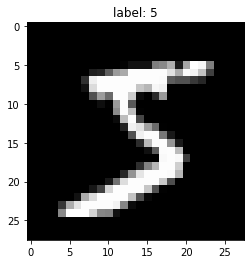

In [ ]:
image, label = train[0]

print(f'image shape: {image.shape}, label: {label}')
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label: %s' % label)
plt.show()

# 미니 배치 구성하기

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=batch_size,
                                          shuffle=True)

first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50])


# CNN 구조 설계하기

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1) 
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x) #(26,26,32) / 28(original size)-3(kernel size)+1
    x = F.relu(x)
    x = self.conv2(x) #(24,24,64) / 26(original size)-3(kernel size)+1
    x = F.relu(x)
    x = F.max_pool2d(x, 2) #(12,12,64) / 24(original size)/2(stride size)
    x = self.dropout1(x)
    x = torch.flatten(x, 1) #(12x12x64)
    x = self.fc1(x) #(128)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x) #(10)
    output = F.log_softmax(x, dim=1)
    return output

# Optimizer 및 손실 함수 정의

In [ ]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# 설계한 CNN 모형 확인하기

In [ ]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# 모델 학습

In [ ]:
model.train()
i = 0
for epoch in range(epoch_num):
  for data, target in train_loader:
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
      print('Train step: {}\tLoss: {:.3f}.'.format(i, loss.item()))
    i += 1

Train step: 0	Loss: 0.024.
Train step: 1000	Loss: 0.031.
Train step: 2000	Loss: 0.048.
Train step: 3000	Loss: 0.035.
Train step: 4000	Loss: 0.076.
Train step: 5000	Loss: 0.056.
Train step: 6000	Loss: 0.098.
Train step: 7000	Loss: 0.006.
Train step: 8000	Loss: 0.002.
Train step: 9000	Loss: 0.004.
Train step: 10000	Loss: 0.007.
Train step: 11000	Loss: 0.029.
Train step: 12000	Loss: 0.002.
Train step: 13000	Loss: 0.015.
Train step: 14000	Loss: 0.044.
Train step: 15000	Loss: 0.030.
Train step: 16000	Loss: 0.014.
Train step: 17000	Loss: 0.002.


# 모델 평가

In [ ]:
model.eval()
correct = 0
for data, target in test_loader:
  data = data.to(device)
  target = target.to(device)
  output = model(data)
  prediction = output.data.max(1)[1]
  correct += prediction.eq(target.data).sum()

print('Test set: Accuracy: {:.2f}%'.format(100 * correct /
                                           len(test_loader.dataset)))

Test set: Accuracy: 99.17%
